Import packages

In [1]:
import importlib
import tensorflow as tf
#import triplet_dataset
import triplet_dataset_arrows as triplet_dataset
importlib.reload(triplet_dataset)
import visualize_embed
importlib.reload(visualize_embed)

<module 'visualize_embed' from 'C:\\Users\\Karun\\Desktop\\embedding-research\\visualize_embed.py'>

Define generic functions to initialize convolutional/pooling layers

In [2]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.01)
    return tf.get_variable("weights", dtype=tf.float32, initializer=initial)

def bias_variable(shape):
    initial = tf.constant(0.01, shape=shape, dtype=tf.float32)
    return tf.get_variable("biases", dtype=tf.float32, initializer=initial)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

def compute_euclidean_distances(x, y):
    d = tf.square(tf.subtract(x, y))
    d = tf.sqrt(tf.reduce_sum(d))
    return d

Define the triplet network architecture in a class

In [3]:
class Triplet:
    
    # Create model
    def __init__(self):
        # Input and label placeholders
        with tf.variable_scope('input'):
            self.x = tf.placeholder(tf.float32, shape=[None, 28, 28, 1], name='x')
            self.xp = tf.placeholder(tf.float32, shape=[None, 28, 28, 1], name='xp')
            self.xn = tf.placeholder(tf.float32, shape=[None, 28, 28, 1], name='xn')
        
        with tf.variable_scope('embedding') as scope:
            self.o = self.embedding_network(self.x)
            scope.reuse_variables()
            self.op = self.embedding_network(self.xp)
            self.on = self.embedding_network(self.xn)
        
        with tf.variable_scope('distances'):
            self.dp = compute_euclidean_distances(self.o, self.op)
            self.dn = compute_euclidean_distances(self.o, self.on)
            self.logits = tf.nn.softmax([self.dp, self.dn], name="logits")
        
        with tf.variable_scope('loss'):
            self.loss = tf.reduce_mean(tf.pow(self.logits[0], 2))
    
    def embedding_network(self, x):
        dim = 1
        with tf.variable_scope('conv1'):
            out = 32
            w = weight_variable([5, 5, dim, out])
            b = bias_variable([out])
            h = max_pool_2x2(tf.nn.relu(conv2d(x, w) + b))
            dim = out
            x = h
        with tf.variable_scope('conv2'):
            out = 64
            w = weight_variable([3, 3, dim, out])
            b = bias_variable([out])
            h = max_pool_2x2(tf.nn.relu(conv2d(x, w) + b))
            dim = out
            x = h
        with tf.variable_scope('conv3'):
            out = 128
            w = weight_variable([3, 3, dim, out])
            b = bias_variable([out])
            h = max_pool_2x2(tf.nn.relu(conv2d(x, w) + b))
            dim = out
            x = h
        with tf.variable_scope('readout'):
            gpool = tf.nn.pool(x, [h.get_shape()[1], h.get_shape()[2]], pooling_type="MAX", padding="VALID", name="gpool")
            return tf.reshape(gpool, [-1, 128])

Prepare the network for training

In [4]:
triplet = Triplet()
train_step = tf.train.GradientDescentOptimizer(0.5).minimize(triplet.loss)

Start training!

C:\Users\Karun\Anaconda2\envs\cs6784\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


step 0, training loss 0.249024
step 5, training loss 0.000624793
step 10, training loss 0.000213862
step 15, training loss 0.000137498
step 20, training loss 0.000113066
step 25, training loss 7.75677e-05
step 30, training loss 9.31859e-05
step 35, training loss 5.30994e-05
step 40, training loss 6.5639e-05
step 45, training loss 5.59175e-05
step 50, training loss 4.74596e-05
step 55, training loss 3.94572e-05
step 60, training loss 4.34543e-05
step 65, training loss 2.39503e-05
step 70, training loss 2.79896e-05
step 75, training loss 3.04587e-05
step 80, training loss 2.57462e-05
step 85, training loss 3.08857e-05
step 90, training loss 2.04445e-05
step 95, training loss 2.97047e-05


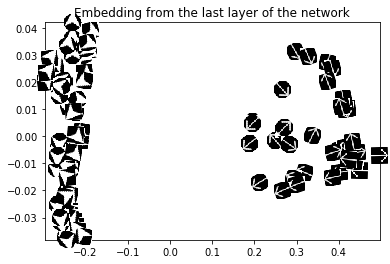

In [6]:
batch_size = 64
logging_frequency = 5
iterations = 100
to_embed = True

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(iterations):
        batch = triplet_dataset.generate_data(batch_size)
        if i % logging_frequency == 0:
            loss = sess.run(triplet.loss, feed_dict={triplet.x: batch[0], triplet.xp: batch[1], triplet.xn: batch[2]}) 
            print('step %d, training loss %g' % (i, loss))
        train_step.run(feed_dict={triplet.x: batch[0], triplet.xp: batch[1], triplet.xn: batch[2]})
    test_batch = triplet_dataset.generate_test(100)
    embed = triplet.o.eval({triplet.x: test_batch})
        
if to_embed:
    visualize_embed.visualize(embed, test_batch[:,:,:,0])